In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#export
import operator


def test(a, b, cmp, cname=None):
    if cname is None:
        cname = cmp.__name__
    
    assert cmp(a, b), f'{cname}:\n{a}\n{b}'


def test_eq(a, b):
    return test(a, b, operator.eq, '==')

In [0]:
test_eq('test', 'test')

# Get data

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
from matplotlib import pyplot as plt
from torch import tensor

MNIST_URL = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [6]:
path = datasets.download_data(MNIST_URL, ext='.gz'); path

PosixPath('/root/.fastai/data/mnist.pkl.gz')

In [0]:
with gzip.open(path, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [9]:
x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
n, c = x_train.shape

x_train.shape, y_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), torch.Size([50000]), tensor(0), tensor(9))

In [0]:
assert n == y_train.shape[0] == 50000
test_eq(c, 28 * 28)
test_eq(y_train.min(), 0)
test_eq(y_train.max(), 9)

In [0]:
mpl.rcParams['image.cmap'] = 'gray'

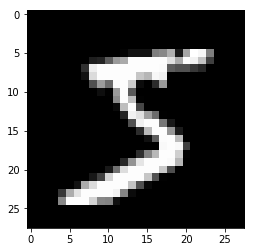

In [12]:
plt.imshow(x_train[0].view(28, 28))

# Initial model (linear model)

In [0]:
weights = torch.randn(784, 10)
bias = torch.zeros(10)

## Matrix multiplication

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                c[i, j] += a[i, k] * b[k, j]
    
    return c

In [0]:
m1 = x_valid[:5]
m2 = weights

In [17]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [18]:
%time t1 = matmul(m1, m2)

CPU times: user 708 ms, sys: 0 ns, total: 708 ms
Wall time: 718 ms


This is pretty slow - what if we could speed it up by 50,000 times? Use element-wise multiplication:

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            c[i, j] = (a[i, :] * b[:, j]).sum()
    
    return c

In [20]:
%timeit -n 10 matmul(m1, m2)

10 loops, best of 3: 1.04 ms per loop


In [0]:
#export
def near(a, b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a, b): test(a, b, near)

In [0]:
test_near(t1, matmul(m1, m2))

Now we need to get rid of the second loop using broadcasting. 

In [0]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    assert ac == br
    
    c = torch.zeros(ar, bc)
    
    for i in range(ar):
        # Broadcast to a rank-2 tensor, and sum up over the rows
        c[i] = (a[i].unsqueeze(-1) * b).sum(dim=0)
    
    return c

In [24]:
%timeit -n 10 matmul(m1, m2)

10 loops, best of 3: 245 µs per loop


### Broadcasting Rules

In [0]:
c = tensor([10., 20., 30.])

In [26]:
c[None, :]

tensor([[10., 20., 30.]])

In [27]:
c[None, :].shape

torch.Size([1, 3])

In [28]:
c[:, None].shape

torch.Size([3, 1])

In [30]:
c[None, :] * c[:, None]

tensor([[100., 200., 300.],
        [200., 400., 600.],
        [300., 600., 900.]])

It does this broadcasting because * is **element-wise** multiplication.

### Einstein summation

Initially, our innermost code was

```{py}
c[i, j] += a[i, k] * b[k, j]
```

So let's remove the variable names, and move the LHS to the end:

```
[i, k] * [k, j] -> [i, j]
```

Now get rid of the commas as the square brackets:

```
ik*kj->ij
```

And our final notation is:

```
ik,kj->ij
```

In [0]:
def matmul(a, b):
    return torch.einsum('ik,kj->ij', a, b)

In [33]:
%timeit -n 10 matmul(m1, m2)

The slowest run took 6.32 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 40.4 µs per loop


In [35]:
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 12.63 times longer than the fastest. This could mean that an intermediate result is being cached.
10 loops, best of 3: 7.47 µs per loop


In [0]:
!python3 notebook2script.py 01_matmul.ipynb